<a href="https://colab.research.google.com/github/ARIVUCHUDAR27/CODSOFT/blob/main/CREDIT_CARD_FRAUD_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")


In [15]:
train_df = pd.read_csv("fraudTrain.csv")
test_df = pd.read_csv("fraudTest.csv")

print(train_df.shape, test_df.shape)
train_df['is_fraud'].value_counts(normalize=True)


(461290, 23) (461266, 23)


,proportion
is_fraud,
0.0,0.993802
1.0,0.006198


In [2]:
sns.set(style='whitegrid')

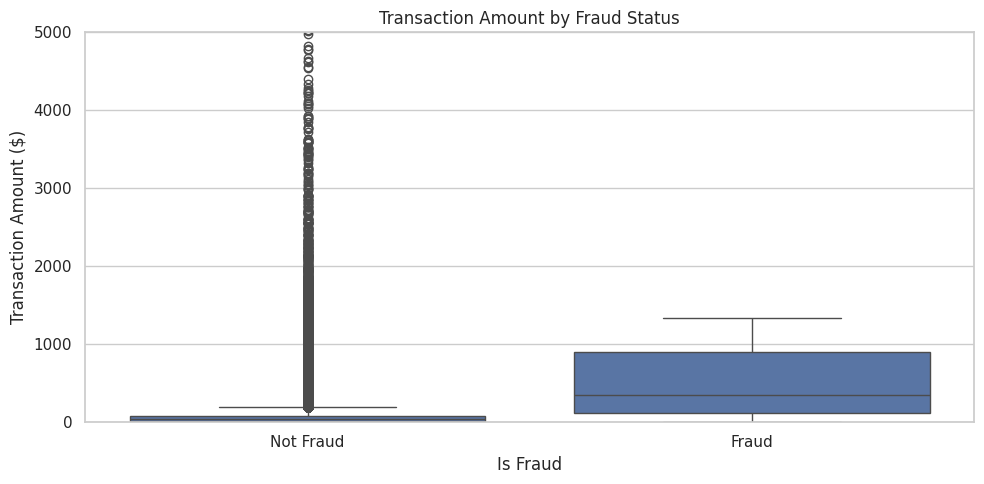

In [17]:
plt.figure(figsize=(10,5))
sns.boxplot(x='is_fraud', y='amt', data=train_df)
plt.ylim(0, 5000)
plt.title('Transaction Amount by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount ($)')
plt.xticks([0,1], ['Not Fraud', 'Fraud'])
plt.tight_layout()
plt.show()

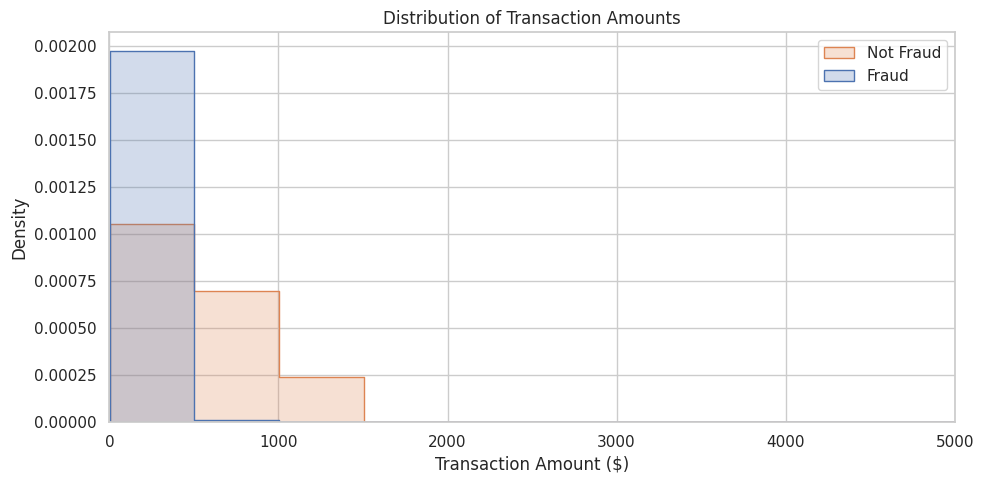

In [18]:
plt.figure(figsize=(10,5))
sns.histplot(data=train_df, x='amt', hue='is_fraud', bins=50, element='step', stat='density', common_norm=False)
plt.xlim(0, 5000)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Transaction Amount ($)")
plt.ylabel("Density")
plt.legend(['Not Fraud', 'Fraud'])
plt.tight_layout()
plt.show()

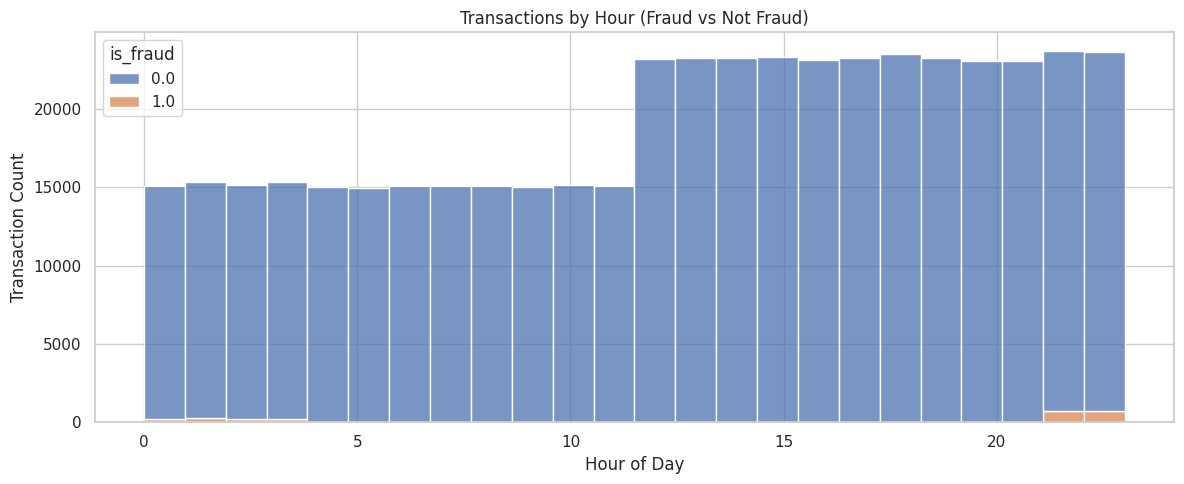

In [19]:
if 'trans_date_trans_time' in train_df.columns:
    train_df['trans_date_trans_time'] = pd.to_datetime(train_df['trans_date_trans_time'])
    train_df['hour'] = train_df['trans_date_trans_time'].dt.hour

    plt.figure(figsize=(12,5))
    sns.histplot(data=train_df, x='hour', hue='is_fraud', bins=24, multiple='stack')
    plt.title("Transactions by Hour (Fraud vs Not Fraud)")
    plt.xlabel("Hour of Day")
    plt.ylabel("Transaction Count")
    plt.tight_layout()
    plt.show()

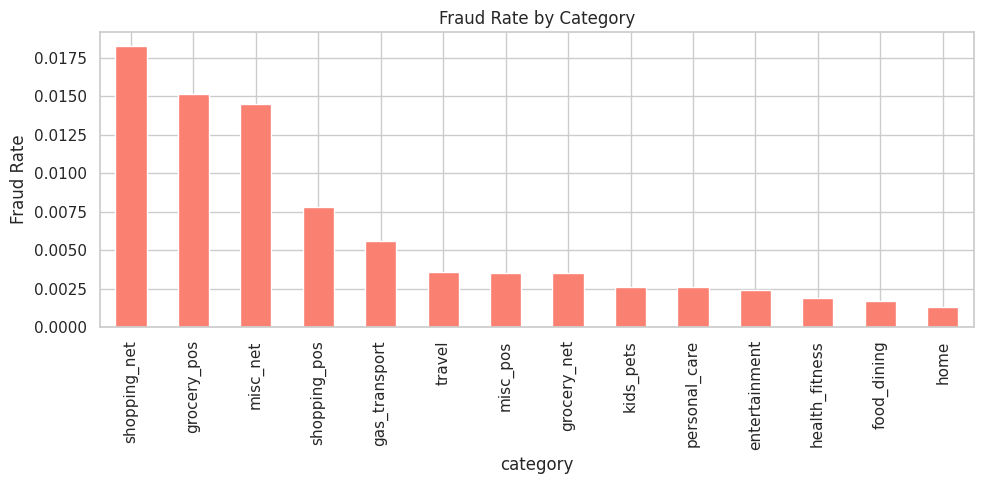

In [20]:
if 'category' in train_df.columns:
    fraud_rate_by_category = train_df.groupby('category')['is_fraud'].mean().sort_values(ascending=False)

    plt.figure(figsize=(10,5))
    fraud_rate_by_category.plot(kind='bar', color='salmon')
    plt.title("Fraud Rate by Category")
    plt.ylabel("Fraud Rate")
    plt.tight_layout()
    plt.show()

In [22]:
df = pd.read_csv("fraudTrain.csv", parse_dates=['trans_date_trans_time'])
df = df.sample(n=20000, random_state=42)

train, test = train_test_split(df, test_size=0.3, stratify=df['is_fraud'], random_state=42)

def preprocess(df):
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['weekday'] = df['trans_date_trans_time'].dt.weekday
    df['age'] = 2022 - pd.to_datetime(df['dob']).dt.year

    df = df.drop(columns=['cc_num', 'first', 'last', 'street', 'trans_num', 'dob', 'trans_date_trans_time'])

    for col in ['merchant', 'category', 'gender', 'state', 'job', 'city']:
        df[col] = df[col].astype('category').cat.codes

    df = df.fillna(0)

    return df

train = preprocess(train)
test = preprocess(test)

X_train = train.drop('is_fraud', axis=1)
y_train = train['is_fraud']
X_test = test.drop('is_fraud', axis=1)
y_test = test['is_fraud']


smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

clf = XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

ROC AUC Score: 0.9279725358156732

Classification Report:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5967
         1.0       0.53      0.70      0.61        33

    accuracy                           0.99      6000
   macro avg       0.77      0.85      0.80      6000
weighted avg       1.00      0.99      1.00      6000


Confusion Matrix:
 [[5947   20]
 [  10   23]]
